In [1]:
from enum import Enum,auto
import pydot
import os
from IPython.display import Image, display
import graphviz

In [2]:
polish_exp = ('m2','m3','v','m1','h','m4','v')
polish_exp

('m2', 'm3', 'v', 'm1', 'h', 'm4', 'v')

In [3]:
attr_dict = {
    'm1': {'width': 1, 'height': 10},
    'm2': {'width': 2, 'height': 5},
    'm3': {'width': 7, 'height': 6},
    'm4': {'width': 4, 'height': 1},
}
attr_dict

{'m1': {'width': 1, 'height': 10},
 'm2': {'width': 2, 'height': 5},
 'm3': {'width': 7, 'height': 6},
 'm4': {'width': 4, 'height': 1}}

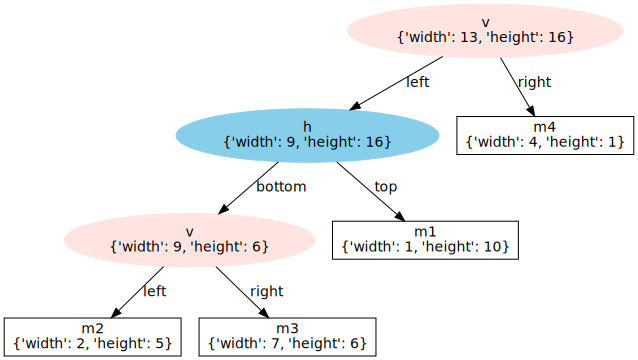

In [4]:
class SliceTree():

    def __init__(self, polish_exp, attr_dict):
        self.attr_dict = attr_dict
        self.polish_exp = polish_exp
        self.root = self.build_tree()

    def visualize_tree(self):
        graph = graphviz.Digraph(str(id(self)), format='png')

        def get_label(node):
            return f'{node.label}\n{str(node.attr)}'

        def add_node_recursive(node, parent_node_id):
            node_id = str(id(node))
            if isinstance(node, SliceTree.LeafNode):
                graph.node(node_id, label=get_label(node), shape='rectangle',
                           color=SliceTree.NODE_COLORS[node.cut])
            else:
                graph.node(node_id, label=get_label(node), shape='oval',
                           color=SliceTree.NODE_COLORS[node.cut], style="filled")

                if isinstance(node, SliceTree.VerticalNode):
                    graph.edge(node_id, add_node_recursive(
                        node.left, node_id), label="left")
                    graph.edge(node_id, add_node_recursive(
                        node.right, node_id), label="right")
                else:
                    graph.edge(node_id, add_node_recursive(
                        node.bottom, node_id), label="bottom")
                    graph.edge(node_id, add_node_recursive(
                        node.top, node_id), label="top")

            return node_id

        add_node_recursive(self.root, None)
        return graph

    def build_tree(self):
        stack = []
        for token in self.polish_exp:
            if token == 'h':
                top = stack.pop()
                bottom = stack.pop()
                stack.append(SliceTree.HorizontalNode(top, bottom))
            elif token == 'v':
                right = stack.pop()
                left = stack.pop()
                stack.append(SliceTree.VerticalNode(left, right))
            else:
                stack.append(SliceTree.LeafNode(token, self.attr_dict[token]))
        return stack.pop()

    class Cut(Enum):
        HORIZONTAL = auto()
        VERTICAL = auto()
        NONE = auto()

    NODE_COLORS = {Cut.HORIZONTAL: 'skyblue',
                   Cut.VERTICAL: 'mistyrose', Cut.NONE: 'black'}

    class LeafNode():
        def __init__(self, label, attr):
            self.label = label
            self.cut = SliceTree.Cut.NONE
            self.attr = attr

    class VerticalNode():
        def __init__(self, left, right):
            self.left = left
            self.right = right
            self.cut = SliceTree.Cut.VERTICAL
            # self.label = f'\<{left.label}\>\<-v-\>\<{right.label}\>'
            self.label = 'v'
            self.attr = {'width': left.attr['width'] + right.attr['width'],
                         'height': max(left.attr['height'], right.attr['height'])}

    class HorizontalNode():
        def __init__(self, top, bottom):
            self.top = top
            self.bottom = bottom
            self.cut = SliceTree.Cut.HORIZONTAL
            self.label = 'h'
            self.attr = {
                'width': max(top.attr['width'], bottom.attr['width']),
                'height': top.attr['height'] + bottom.attr['height']}


slice_tree = SliceTree(polish_exp, attr_dict)
gp = slice_tree.visualize_tree()
gp


In [5]:
graph = graphviz.Digraph(format='png')

# get the root of the SliceTree
root = slice_tree.root

# define a function to visualize each node recursively
def visualize_node(node, parent_node_id):
    node_id = str(id(node))
    # create a rectangle node
    graph.node(node_id, label=node.label, shape='rectangle', 
               width=str(node.attr['width']/100), 
               height=str(node.attr['height']/100), 
               color=SliceTree.NODE_COLORS[node.cut], 
               style="filled")
    # add an edge from the parent node to this node
    if parent_node_id:
        graph.edge(parent_node_id, node_id)
    # if this node is a horizontal node, visualize its top and bottom children
    if isinstance(node, SliceTree.HorizontalNode):
        visualize_node(node.top, node_id)
        visualize_node(node.bottom, node_id)
    # if this node is a vertical node, visualize its left and right children
    elif isinstance(node, SliceTree.VerticalNode):
        visualize_node(node.left, node_id)
        visualize_node(node.right, node_id)

# start visualizing the tree from the root
visualize_node(root, None)

# save the graph to a file
graph.render("slice_tree_graph")

'slice_tree_graph.png'

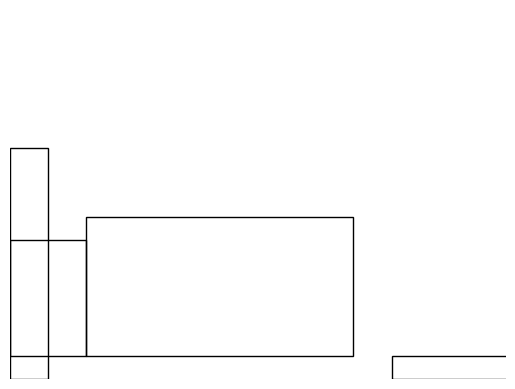

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_rectangle(node, x, y, ax):
    width = node.attr['width']
    height = node.attr['height']
    rect = patches.Rectangle((x,y), width, height, linewidth=1, edgecolor='black', facecolor='none')
    ax.add_patch(rect)
    return width, height

def plot_node(node, x, y, ax):
    if isinstance(node, SliceTree.LeafNode):
        width, height = plot_rectangle(node, x, y, ax)
    elif isinstance(node, SliceTree.VerticalNode):
        width_left, height_left = plot_node(node.left, x, y, ax)
        width_right, height_right = plot_node(node.right, x + width_left, y, ax)
        width = width_left + width_right
        height = max(height_left, height_right)
    else:
        height_top, width_top = plot_node(node.top, x, y, ax)
        height_bottom, width_bottom = plot_node(node.bottom, x, y + height_top, ax)
        width = max(width_top, width_bottom)
        height = height_top + height_bottom
    return width, height

fig, ax = plt.subplots()
plot_node(slice_tree.root, 0, 0, ax)
ax.set_xlim([0, slice_tree.root.attr['width']])
ax.set_ylim([0, slice_tree.root.attr['height']])
plt.axis('off')
plt.show()


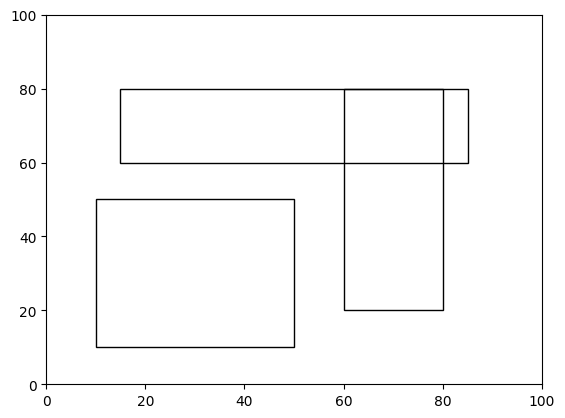

In [7]:
import matplotlib.pyplot as plt

def plot_floor_plan(floor_plan):
    fig, ax = plt.subplots()
    for room in floor_plan:
        x, y, width, height = room
        rect = plt.Rectangle((x, y), width, height, linewidth=1, edgecolor='black', facecolor='none')
        ax.add_patch(rect)
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 100)
    plt.show()

floor_plan = [(10, 10, 40, 40), (60, 20, 20, 60), (15, 60, 70, 20)]
plot_floor_plan(floor_plan)